In [15]:
import pandas as pd
import networkx as nx

## Functions

### Extract ID

In [1]:
def extract_id_from_url(url):
    if pd.isna(url) or not isinstance(url, str):
        return None
    try:
        # Remove any query parameters or fragments
        clean_url = url.split('?')[0].split('#')[0]
        # Extract the last part of the URL and convert to int
        return int(clean_url.rstrip('/').split('/')[-1])
    except (ValueError, AttributeError, IndexError):
        return None

### Build connections dataframe

In [13]:
def build_connections_dataframe(dfObservations, dfAnimals):
    # Filter observations to only include valid eater records
    eater_obs = dfObservations[
        (dfObservations['eater'] == 'eater') & 
        dfObservations['partner_id'].notna()
    ].copy()

    # Merge with dfAnimals to get details
    eater_merged = pd.merge(
        eater_obs,
        dfAnimals,
        left_on='scientific_name',
        right_on='scientific_name',
        how='inner'
    )

    # Rename columns
    eater_merged = eater_merged.rename(columns={
        'id_x': 'observation_id',
        'id_y': 'eater_id',
        'scientific_name': 'eater_scientific_name',
        'common_name_x': 'eater_common_name',
        'iconic_taxon_name_x': 'eater_category'
    })

    # Dropping columns
    eater_merged = eater_merged.drop(columns=[
        'species_guess',
        'time_observed_at',
        'partner',
        'common_name_y',
        'iconic_taxon_name_y',
        'eater'
    ])

    # Get eaten observations
    eaten_obs = dfObservationsT[['id', 'scientific_name']].rename(columns={
        'id': 'partner_id',
        'scientific_name': 'eaten_scientific_name'
    })

    # Merge to get eaten details
    eater_merged = pd.merge(
        eater_merged,
        eaten_obs,
        on='partner_id',
        how='inner'
    )

    # Merge with dfAnimals to get eaten animal details
    eater_merged = pd.merge(
        eater_merged,
        dfAnimals.rename(columns={
            'scientific_name': 'eaten_scientific_name',
            'id': 'eaten_id',
            'common_name': 'eaten_common_name',
            'iconic_taxon_name': 'eaten_category'
        }),
        on='eaten_scientific_name',
        how='left'
    )

    # Calculate frequency of each connection
    eater_merged['frequency'] = 1
    eater_merged = eater_merged.groupby([
        'observation_id',
        'eater_id',
        'eater_scientific_name',
        'eater_common_name',
        'eater_category',
        'eaten_id',
        'eaten_scientific_name',
        'eaten_common_name',
        'eaten_category'
    ])['frequency'].sum().reset_index()

    eater_merged['eaten_id'] = eater_merged['eaten_id'].astype('Int64')

    # Select and order final columns
    final_connections = eater_merged[[
        'observation_id',
        'eater_id',
        'eater_scientific_name',
        'eater_common_name',
        'eater_category',
        'eaten_id',
        'eaten_scientific_name',
        'eaten_common_name',
        'eaten_category',
        'frequency'
    ]]

    return final_connections

### Build network from connections

In [16]:
def build_network_from_connections(dfConnections, dfAnimals):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with attributes
    for _, row in dfAnimals.iterrows():
        G.add_node(
            row['id'],
            scientific_name=row['scientific_name'],
            common_name=row['common_name'],
            category=row['iconic_taxon_name']
        )

    # Add edges with weight from frequency
    for _, row in dfConnections.iterrows():
        if pd.notna(row['eaten_id']):  # Only add edges where eaten_id is not null
            G.add_edge(
                row['eater_id'],
                int(row['eaten_id']), 
                weight=row['frequency']
            )
            
    # Clean the graph data
    for node, data in G.nodes(data=True):
        for key, value in list(data.items()):
            if value is None:
                data[key] = ""

    # Clean edge attributes
    for u, v, data in G.edges(data=True):
        for key, value in list(data.items()):
            if value is None:
                data[key] = ""
    
    return G

## Data Loading

In [8]:
dfObservations = pd.read_csv("../data/observations.csv")
dfObservations.head()

,id,uuid,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,...,geoprivacy,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id,"field:id meant for ""eater"" or organism being eaten?","field:url for ""partner"" observation",field:is observation one of these special types of feeding?
0,10686,6662b18b-6343-460b-90e8-d494df9766e8,2006-07-01,2006-07-01,NaN,Eastern Time (US & Canada),520,johnnybirder,Johnny Wilson,2011-01-30 08:03:49 -0700,...,NaN,NaN,House Mouse,Mus musculus,House Mouse,Mammalia,44705,eater,https://www.inaturalist.org/observations/1766953,"No, none of these"
1,338604,c127ae38-c311-40bb-bc5f-2e48d8e02c59,2012-08-19 8:00 AM,2012-08-19,2012-08-19 07:00:00 -0600,Central Time (US & Canada),17056,fvaldesp_tutor,Francisco Valdes Perezgasga,2013-07-19 16:24:55 -0600,...,NaN,NaN,Correcaminos norteño,Geococcyx californianus,Greater Roadrunner,Aves,1986,eater,NaN,"No, none of these"
2,414645,8900f5f2-3c54-4397-b215-7033ab0c0e4b,1988-07-13,1988-07-13,NaN,Harare,23072,i_c_riddell,NaN,2013-10-02 02:14:16 -0600,...,NaN,NaN,Cape Wolf Snake,Lycophidion capense,Cape Wolf Snake,Reptilia,29508,eater,https://www.inaturalist.org/observations/414707,NaN
3,414707,f71bf6a5-7cc2-49c3-b5dd-df5716f5cb32,1988-07-13,1988-07-13,NaN,Harare,23072,i_c_riddell,NaN,2013-10-02 02:47:17 -0600,...,NaN,NaN,Sundevall's Writhing Skink,Mochlus sundevallii,Sundevall's Writhing Skink,Reptilia,37932,thing being eaten,https://www.inaturalist.org/observations/414645,NaN
4,420386,56bf357d-9c01-4e0a-8cdb-a4f7aa548081,2013-10-06 15:10:40,2013-10-06,2013-10-06 13:10:40 -0600,Eastern Time (US & Canada),12796,scadwell,Suzanne Cadwell,2013-10-06 16:55:37 -0600,...,NaN,manual,Eastern Kingsnake,Lampropeltis getula,Eastern Kingsnake,Reptilia,29813,NaN,NaN,NaN


## Data Transformation

#### Transforming dataset

In [9]:
dfObservationsT = dfObservations.copy()
columns = [
    'id',
    'species_guess',
    'scientific_name',
    'common_name',
    'iconic_taxon_name',
    'time_observed_at',
    'field:id meant for "eater" or organism being eaten?',	
    'field:url for "partner" observation'
]

# Getting relevant columns and renaming
dfObservationsT = dfObservationsT[columns]
dfObservationsT = dfObservationsT.rename(columns={
    'field:id meant for "eater" or organism being eaten?': 'eater',
    'field:url for "partner" observation': 'partner',
})

# Apply the function to create a new column 'partner_id'
dfObservationsT['partner_id'] = dfObservationsT['partner'].apply(extract_id_from_url)

# Convert to Int64 type which supports NA values
dfObservationsT['partner_id'] = dfObservationsT['partner_id'].astype('Int64')

dfObservationsT.head()

,id,species_guess,scientific_name,common_name,iconic_taxon_name,time_observed_at,eater,partner,partner_id
0,10686,House Mouse,Mus musculus,House Mouse,Mammalia,NaN,eater,https://www.inaturalist.org/observations/1766953,1766953
1,338604,Correcaminos norteño,Geococcyx californianus,Greater Roadrunner,Aves,2012-08-19 07:00:00 -0600,eater,NaN,<NA>
2,414645,Cape Wolf Snake,Lycophidion capense,Cape Wolf Snake,Reptilia,NaN,eater,https://www.inaturalist.org/observations/414707,414707
3,414707,Sundevall's Writhing Skink,Mochlus sundevallii,Sundevall's Writhing Skink,Reptilia,NaN,thing being eaten,https://www.inaturalist.org/observations/414645,414645
4,420386,Eastern Kingsnake,Lampropeltis getula,Eastern Kingsnake,Reptilia,2013-10-06 13:10:40 -0600,NaN,NaN,<NA>


### Animals dataframe

In [11]:
# Group by scientific_name and take the first occurrence of other columns
dfAnimals = dfObservationsT.groupby('scientific_name', as_index=False).agg({
    'common_name': 'first',
    'iconic_taxon_name': 'first'
}).reset_index(drop=True)

# Create an ID column from the scientific_name (you can use different encoding if needed)
dfAnimals['id'] = dfAnimals['scientific_name'].astype('category').cat.codes + 1

# Reorder columns to have id first
dfAnimals = dfAnimals[['id', 'scientific_name', 'common_name', 'iconic_taxon_name']]

# Save to a CSV file
dfAnimals.to_csv('../data/animals.csv', index=False)

# Display the result
dfAnimals.head()

,id,scientific_name,common_name,iconic_taxon_name
0,1,Abantennarius sanguineus,Bloody Frogfish,Actinopterygii
1,2,Abantis paradisea,Paradise Skipper,Insecta
2,3,Abbottina rivularis,Chinese False Gudgeon,Actinopterygii
3,4,Abisares viridipennis,Notched Shield Grasshopper,Insecta
4,5,Abramis brama,Common Bream,Actinopterygii


### Connections dataframe

In [14]:
dfConnections = build_connections_dataframe(dfObservations = dfObservationsT, dfAnimals = dfAnimals)
dfConnections.head()

,observation_id,eater_id,eater_scientific_name,eater_common_name,eater_category,eaten_id,eaten_scientific_name,eaten_common_name,eaten_category,frequency
0,10686,3037,Mus musculus,House Mouse,Mammalia,3415,Pachyptila vittata,Broad-billed Prion,Aves,1
1,414645,2748,Lycophidion capense,Cape Wolf Snake,Reptilia,3003,Mochlus sundevallii,Sundevall's Writhing Skink,Reptilia,1
2,465679,2735,Lutra capensis capensis,Cape Clawless Otter,Mammalia,72,Actinopterygii,Ray-finned Fishes,Actinopterygii,1
3,509046,1473,Dendroaspis polylepis,Black Mamba,Reptilia,3803,Ploceus cucullatus,Village Weaver,Aves,1
4,518909,1031,Chamaeleo namaquensis,Namaqua Chameleon,Reptilia,4684,Tenebrionidae,Darkling Beetles,Insecta,1


### Build Network

In [17]:
# Building network
G = build_network_from_connections(dfConnections, dfAnimals)

# Write network
nx.write_gexf(G, '../data/original_animal_network.gexf', encoding='utf-8', prettyprint=True)

# Basic network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average in-degree: {sum(dict(G.in_degree()).values()) / G.number_of_nodes():.2f}")
print(f"Average out-degree: {sum(dict(G.out_degree()).values()) / G.number_of_nodes():.2f}")

Number of nodes: 5159
Number of edges: 2906
Average in-degree: 0.56
Average out-degree: 0.56


## Plots

### Degree by Category

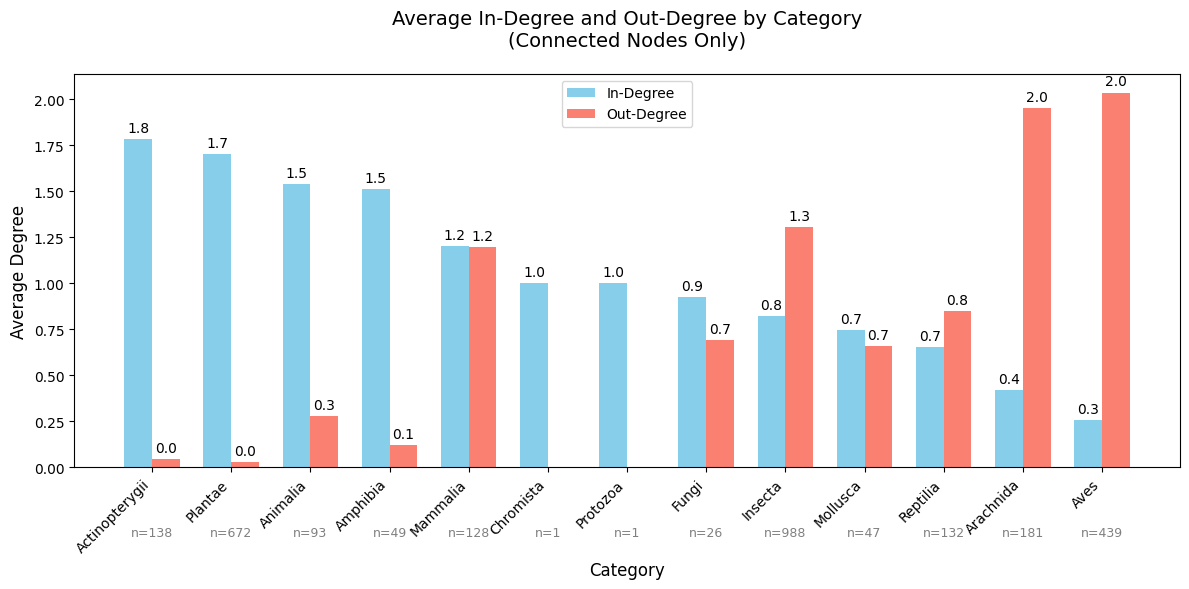

In [22]:
G_filtered = G.copy()
    
# Remove isolated nodes (nodes with no edges)
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

# Calculate in-degree and out-degree for each remaining node
in_degree = dict(G_filtered.in_degree())
out_degree = dict(G_filtered.out_degree())

# Get categories for each node
categories = [data.get('category', 'Unknown') for _, data in G_filtered.nodes(data=True)]

# Create a DataFrame with degree information
degree_df = pd.DataFrame({
    'node': list(G_filtered.nodes()),
    'in_degree': [in_degree[n] for n in G_filtered.nodes()],
    'out_degree': [out_degree[n] for n in G_filtered.nodes()],
    'category': categories
})

# Calculate mean degrees by category
degree_by_category = degree_df.groupby('category').agg({
    'in_degree': 'mean',
    'out_degree': 'mean',
    'node': 'count'  # Add count of nodes per category
}).rename(columns={'node': 'node_count'}).reset_index()

# Sort categories by in-degree for better visualization
degree_by_category = degree_by_category.sort_values('in_degree', ascending=False)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set width of bars
bar_width = 0.35
index = np.arange(len(degree_by_category))

# Plot bars
rects1 = ax.bar(index - bar_width/2, 
                degree_by_category['in_degree'], 
                bar_width, 
                label='In-Degree',
                color='skyblue')

rects2 = ax.bar(index + bar_width/2, 
                degree_by_category['out_degree'], 
                bar_width, 
                label='Out-Degree',
                color='salmon')

# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Average Degree', fontsize=12)
ax.set_title('Average In-Degree and Out-Degree by Category\n(Connected Nodes Only)', 
            fontsize=14, pad=20)
ax.set_xticks(index)
ax.set_xticklabels(degree_by_category['category'], rotation=45, ha='right')
ax.legend()

# Add value labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        if not pd.isna(height) and height > 0:  # Only add label if height is valid
            ax.annotate(f'{height:.1f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

# Add count of nodes per category below x-axis
for i, (count, in_deg) in enumerate(zip(degree_by_category['node_count'], 
                                        degree_by_category['in_degree'])):
    ax.text(i, -0.15 * ax.get_ylim()[1], f'n={count}',
            ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()